# Solutions
## Measure 20 MHz signal

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import signal
import pandas as pd
import numpy as np
import time
from epics import PV

plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.which'] = "both"
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['font.size'] = 8

In [2]:
fs = 480 * 23 / 24 / 4  # MHz
fullscale = 1 << (16 - 1)  # signed 16 bit format, AD9653

In [3]:
def calc_ps(wfm, title='', fullscale=32767, fs_mhz=115, average=False):
    fsdb = 20 * np.log10(fullscale / np.sqrt(2))
    f, pxx = signal.periodogram(
        wfm, fs_mhz, 'flattop', scaling='spectrum')
    # optional average pxx for waveform array
    if len(pxx.shape) == 2 and average:
        pxx = np.mean(pxx, axis=0)
    psd_dbfs = 10 * np.log10(pxx) - fsdb
    return f, psd_dbfs

def plot_ps(f, psd_dbfs, title='', annotate=False):
    fig, ax = plt.subplots()
    ax.set_xlabel('Freq [MHz]')
    ax.set_ylabel('Mag [dBFS]')
    ax.set_ylim(-120, 0)
    ax.set_title(title)
    if len(psd_dbfs.shape) == 1:
        ax.plot(f, psd_dbfs)
        if annotate:
            idx = np.argmax(psd_dbfs)
            pwr = psd_dbfs[idx]
            ax.annotate(
                f'{f[idx]:5.3f}  MHz\n {pwr:5.3f} dBFS',
                xy=(f[idx], pwr), xytext=(1, -20),
                arrowprops=dict(shrink=0.05))
    elif len(psd_dbfs.shape) == 2:   # plot psd array
        for ix, p in enumerate(psd_dbfs):
            ax.plot(f, p, label='adc' + str(ix))
        ax.legend()

In [4]:
pvs = {
    f'adc{8-i}': PV(f'USPAS:LLRF:reg_adc{i}_buf_RBV')
    for i in range(8)}

## Using LLRF as a specrrum analyzer

Measure `ADC1` and `ADC8` 8 times for spectrum averaging. First measure `ADC8` which has no input signal.

In [5]:
adc1_dat_array = []
for _ in range(8):
    adc1_dat_array.append( pvs['adc8'].value)
    time.sleep(0.5)  # EPICS polling rate

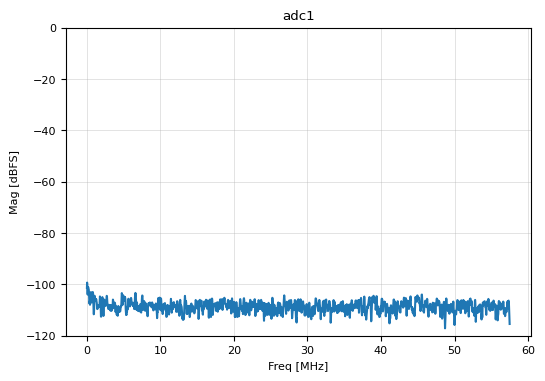

In [6]:
f, psd_dbfs = calc_ps(adc1_dat_array, average=True)
plot_ps(f, psd_dbfs, title='adc1')

> What's the frequency resolution of the power spectrum?

In [7]:
print(f'Freq resolution: {fs / adc1_dat_array[0].size:.6f} MHz')
print(f'Freq resolution: {np.diff(f).mean():.6f} MHz')
f_bin = np.diff(f).mean()

Freq resolution: 0.028076 MHz
Freq resolution: 0.028076 MHz


> For the connected channel, what's the measured peak frequency?

Set signal source at +5 dBm, connect to `ADC1`.

In [8]:
adc1_dat_array = []
for _ in range(8):
    adc1_dat_array.append( pvs['adc1'].value)
    time.sleep(0.5)  # EPICS polling rate

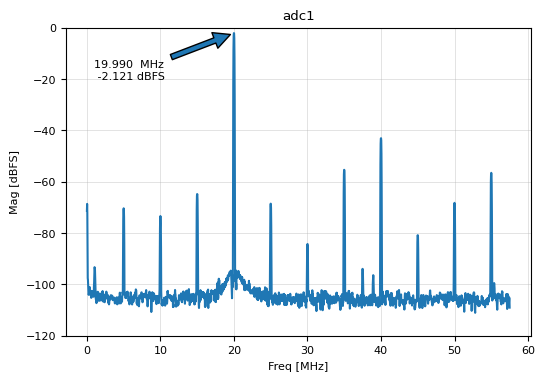

In [9]:
f, psd_dbfs = calc_ps(adc1_dat_array, average=True)
plot_ps(f, psd_dbfs, title='adc1', annotate=True)

> Compare the plotted spectrum with Figure 8 on page 14 in [AD9653 datasheet](https://www.analog.com/media/en/technical-documentation/data-sheets/ad9653.pdf), does the ADC function as expected in terms of noise floor and Signal Noise Ratio (SNR)?

Yes. The datasheet figure uses 16K FFT, which has addtional analysis gain of $10\log(16384) - 10\log(4096) = 13.86$ dB, which explains the noise floor difference. 
The SNR is specified as 76.8 dB, which is reasonably close to the measured noise floor at 20 MHz.
A true measurement needs to numerically deduct the signal itself in order to measure the actual noise floor at 20 MHz, which tends to increase
hen the input signal is closer to full scale.

# Finding ADC full scale

+7.1 dBm

## Harmonic distortion

In [10]:
def find_known_harm_index(fft_freq, num=4, den=23, n_harm=5):
    """
    Returns the location of known harmnics that aliased in nyquist zone at `f`::
        f = +- k*fs +- n*fin
    Where fs is sampling frequency, fin is carrier signal. Note DC is not included.

    :param array fft_freq :  Normalized fft frequency.
    :param int num :         Numerator of fin/fs.
    :param int den :         Denominator of fin/fs.
    :param int n_harm:       Number of harmonics.
    :return array peakinds:  Index array of alias harmonics peaks in fft_freq
    :return array alias_f:   Normalized frequency array of alias harmonics peaks.
    """
    harm_f = np.arange(1, 1+n_harm) * num / den
    alias_f = []
    for f in harm_f:
        for k in range(-3, 3):
            if   0 < k+f < .5: alias_f.append(k+f)
            elif 0 < k-f < .5: alias_f.append(k-f)

    peakinds = []
    fft_bin = .5/fft_freq.size
    for f in alias_f:
        index = np.where(
            np.logical_and(fft_freq <= f+fft_bin,
            fft_freq >= f-fft_bin))[0]
        if index[0]: peakinds.append(index[0])
    return peakinds, np.array(alias_f)


In [11]:
peakinds, basis_f = find_known_harm_index(f / fs)

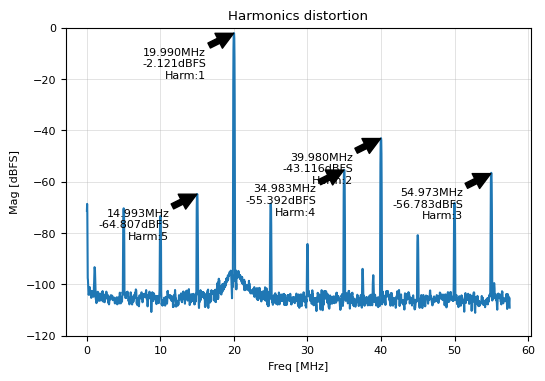

In [12]:
fig, ax = plt.subplots()
ax.set_xlabel('Freq [MHz]')
ax.set_ylabel('Mag [dBFS]')
ax.set_ylim(-120, 0)
ax.set_title('Harmonics distortion')
ax.plot(f, psd_dbfs)

for i,index in enumerate(peakinds[:5]):
    xpos = f[index]
    ypos = psd_dbfs[index]
    ax.annotate('{:.3f}MHz\n{:.3f}dBFS\nHarm:{:1d}'.format(
        xpos,
        ypos, i+1),
        fontsize=8,
        xy=(xpos, ypos), xycoords='data',
        xytext=(-20, -10), textcoords='offset points',
        arrowprops=dict(facecolor='black', shrink=0.01),
        horizontalalignment='right',
        verticalalignment='top')


## Measure channel-to-channel isolation

In [13]:
all_adcs_dat = np.array([
    pvs[f'adc{i+1}'].value for i in range(8)])
f, psd_dbfs_array = calc_ps(all_adcs_dat)

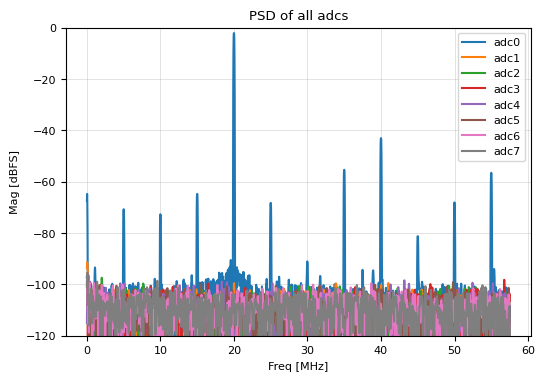

In [14]:
plot_ps(f, psd_dbfs_array, title='PSD of all adcs')

In [15]:
np.savetxt(
    'adc_dat.csv', all_adcs_dat.T,
    fmt='%10d', header=' '.join(pvs.keys()))